#  WEEKLY Covid test data for Devon

### Data availability

Data on Covid is available for the UK from https://coronavirus.data.gov.uk/details/download.  

* For England as a whole: daily case data is available (including people who have had at least one positive COVID-19 test result). In this, data are shown by the date the sample was taken from the person being tested. Definition at: https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDate  

* For MSOAs: weekly case data is available, showing the number of new cases within a 7 day period. Definition at https://coronavirus.data.gov.uk/metrics/doc/newCasesBySpecimenDateRollingSum


### Script functionality
This script compares the weekly case data from the government website, with the daily case data (previously downloaded from government website?).  
Plots cases over time for both the whole of Devon and for individual MSOAs.  


### Conclusions
Weekly case data at MSOA level has lots of missing values - or does this just represent 0 cases?  
There are no dates for which there are values for all MSOAs and there are no MSOAs for which there are all the values.  
Additionally, where there are values there are generally around a factor of 10 lower than in the daily cases summed to weekly.

In [712]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import datetime
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import numpy as np  
import matplotlib.cm as cm

## Download COVID test data for the UK from government website

In [713]:
# define url to get data from
new_url = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=msoa&metric=newCasesBySpecimenDateRollingSum&metric&format=csv'
df = pd.read_csv(new_url)

# And filter to time period
# start, end = "2020-04-01", "2020-12-12"
# query_string = 'date >= "{}" & date <= "{}"'.format(start, end)
# df = df.query(query_string)

## Keep only data for MSOAs in Devon, and reformat

In [760]:
weekly_cases_msoas =df.copy()

# rename column to MSOA11CD
weekly_cases_msoas.rename(columns={"areaCode": "MSOA11CD", "date": "Date"}, inplace = True)

# set MSOA codes as index
weekly_cases_msoas = weekly_cases_msoas.set_index('MSOA11CD', drop=True)

# Reverse order of data (was starting from most recent date)
weekly_cases_msoas = weekly_cases_msoas.iloc[::-1]

# Convert to datetime (and then to just date)
weekly_cases_msoas['Date'] = pd.to_datetime(weekly_cases_msoas['Date'], format='%Y-%m-%d').dt.date
# Order by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)

######### Just devon
# Load csv containing codes of msoas in Devon
devon_msoa_codes =pd.read_csv("devon_msoa_codes.csv").set_index('MSOA11CD', drop=True,verify_integrity=True)

# Keep only MSOA codes in Devon
weekly_cases_msoas = weekly_cases_msoas.join(other=devon_msoa_codes, how="inner")

# Keep only relevant columns
weekly_cases_msoas = weekly_cases_msoas[['Date', 'newCasesBySpecimenDateRollingSum']]

weekly_cases_msoas.head()

,Date,newCasesBySpecimenDateRollingSum
MSOA11CD,,
E02004129,2020-05-02,3
E02004129,2020-10-31,5
E02004129,2020-11-07,3
E02004129,2020-11-14,9
E02004129,2020-11-21,6


### Convert format
Previous format: 2 columns, one with dates, one with cases numbers, MSOA code as index  
New format: One column with date, column for each MSOA containing cases numbers on each date

In [715]:
# Create dataframe containing the dates for which there are data in at least one MSOA
dates = pd.DataFrame({'Date':weekly_cases_msoas['Date'].unique()})
# Create list to store dataframe for each MSOA
list_dfs = []
# Loop through MSOAs and convert the format into a dataframe with a column for dates and a column for case values in that MSOA
# Join it to the list of dates with data in any MSOA
# Add to list of dataframes
for msoa_code in weekly_cases_msoas.index.unique().values:
    # get data for just one MSOA
    one_msoa = weekly_cases_msoas[weekly_cases_msoas.index ==msoa_code ]
    #print(one_msoa)
    # Create column as well as index (needed in pivot?)
    one_msoa.reset_index(level=0, inplace=True)
    # Pivot the format of the data so...
    piv = one_msoa.pivot(index = 'MSOA11CD', columns = 'Date')['newCasesBySpecimenDateRollingSum']
    # Transpose it so...
    piv_t = piv.T
    piv_t.reset_index(drop = False, inplace = True)
    # Join to dates
    piv_t = pd.merge(dates, piv_t, on=["Date"], how = 'left')
    if not list_dfs:
        list_dfs.append(piv_t)
    else:
        list_dfs.append(piv_t[msoa_code])
        
# Join list of dataframes into one        
weekly_cases_msoas = pd.concat(list_dfs, axis=1)
# Sort by date
weekly_cases_msoas.sort_values(by='Date', inplace =True)

weekly_cases_msoas = weekly_cases_msoas[0:53].reset_index(drop = True)
weekly_cases_msoas

,Date,E02004129,E02004130,E02004131,E02004132,E02004133,E02004134,E02004135,E02004136,E02004137,...,E02004226,E02004227,E02004228,E02004229,E02004230,E02004231,E02004232,E02004233,E02004234,E02004235
0,2020-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
2,2020-04-11,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-18,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,17.0,NaN,NaN,NaN,NaN,NaN,5.0,7.0,NaN
4,2020-04-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
5,2020-05-02,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN
6,2020-05-09,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-05-30,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Replace NaNs with 0
This is where individual MSOAs didn't have data for some of the dates in the period

In [716]:
weekly_cases_msoas = weekly_cases_msoas.fillna(0)

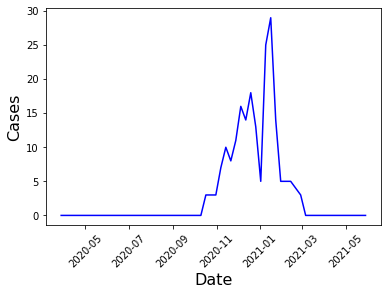

In [717]:
msoa_code = "E02004130"
one_msoa = weekly_cases_msoas[['Date', msoa_code]]
# shared axis
fig, ax = plt.subplots()
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(one_msoa['Date'], one_msoa[msoa_code], label="Shifted cases", color="blue")

## Plot data for each MSOA individually

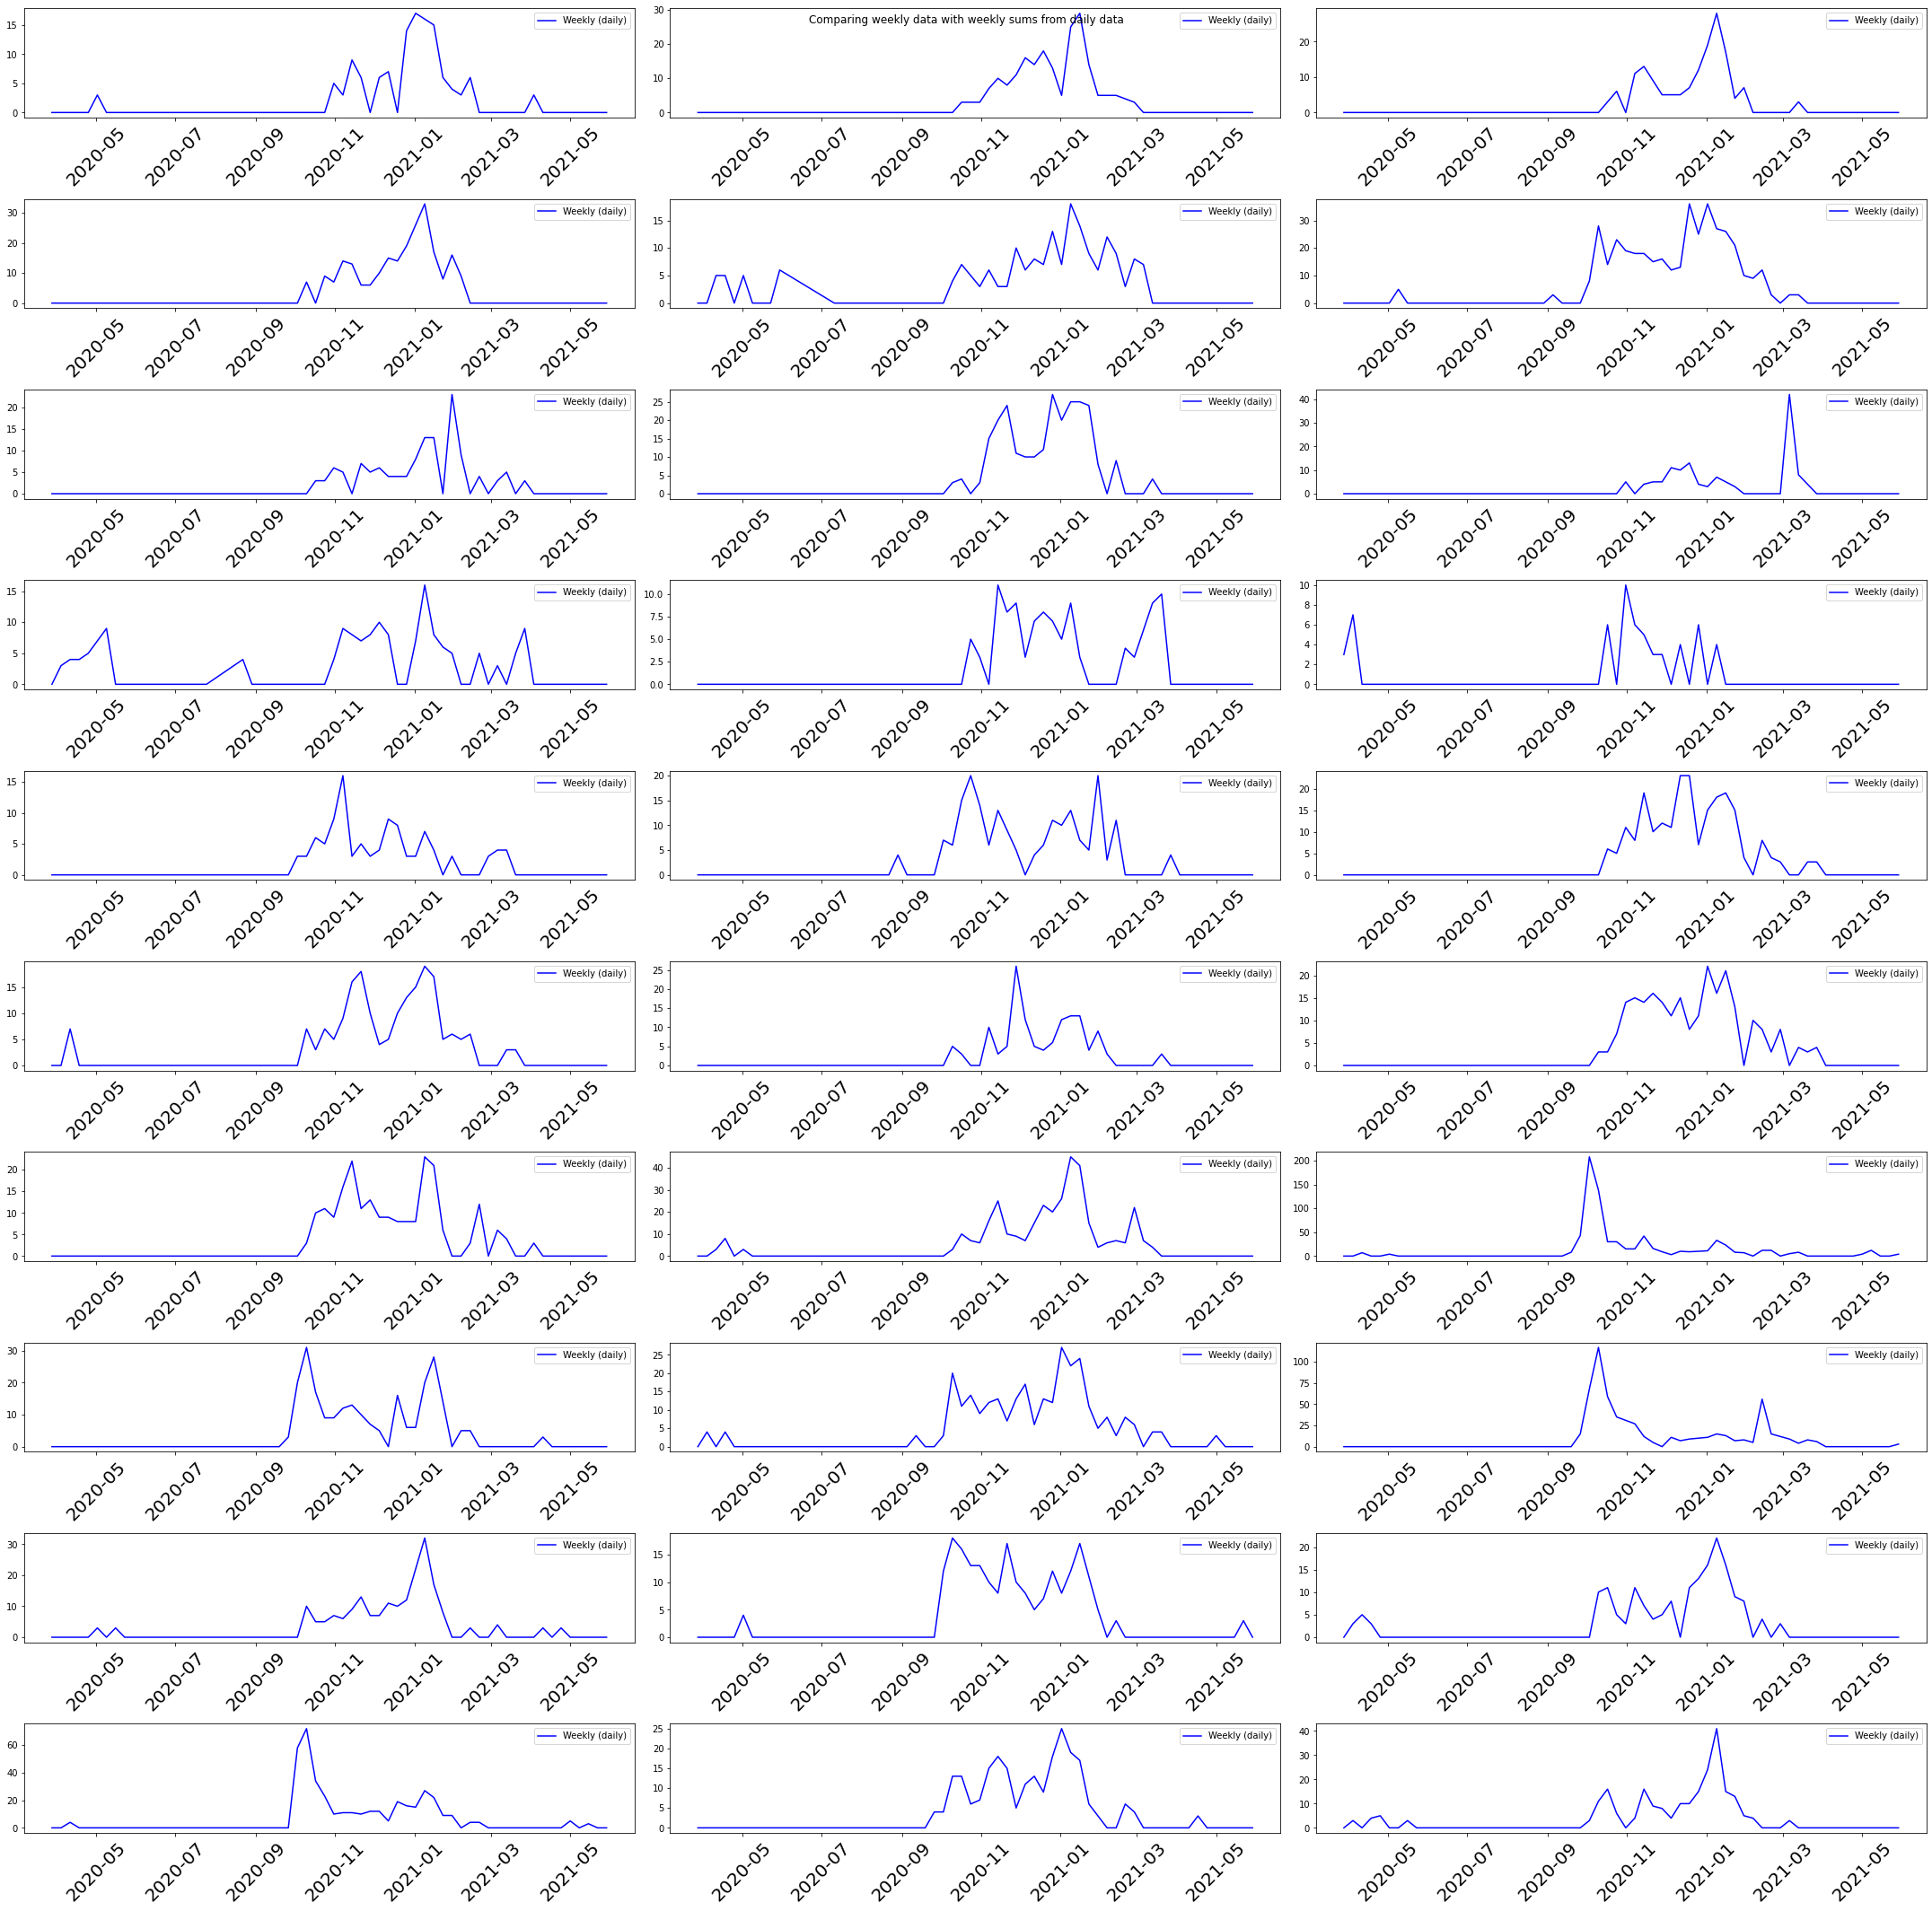

In [718]:
msoa_codes = weekly_cases_msoas.columns[1:]
fig, axs = plt.subplots(figsize =(30,30), nrows=10, ncols=3, sharey=False)
for i, ax in enumerate(fig.axes):
    msoa_code = msoa_codes[i]
    one_msoa = weekly_cases_msoas[['Date', msoa_code]]
       
    ax.plot(one_msoa['Date'], one_msoa[msoa_code], label="Weekly (daily)", color="blue")
    #ax.set_xlabel("Date", fontsize= 16)
    #ax.set_xlabel("Date", fontsize= 16)
    ax.tick_params(axis='x', labelrotation=45, labelsize = 20 )
    ax.legend()
plt.suptitle("Comparing weekly data with weekly sums from daily data")
fig.tight_layout()
plt.show()

## Combine data for whole of Devon

Create a dataframe containing info on cases across the WHOLE of Devon, with:  
* One column with dates
* One column with the number of new cases on each date
* One column with the cumulative number of cases so far on that date

### Find total number of cases over whole of Devon

In [719]:
def find_devon_totals(df):
    totals_df = df.copy()
    # Add a row with the total number of cases across all MSOAs in each day
    totals_df['OriginalCases']= totals_df.iloc[:, 1:].sum(axis=1)
    # Remove columns with individual values for each MSOA
    totals_df = totals_df.drop(totals_df.iloc[:, 1:-1].columns, axis=1)
    totals_df.reset_index(inplace = True, drop = True)
#     # Find the cumulative cases
#     totals_df['CumulativeCases'] = totals_df['Total_obs'].cumsum()
#     # Rename column
#     totals_df.rename(columns={"Total_obs": "Cases"}, inplace = True)
    # Sort by date
    totals_df.sort_values(by='Date', inplace =True)
    return totals_df
    
weekly_cases_devon = find_devon_totals(weekly_cases_msoas) 
weekly_cases_devon.head()

,Date,OriginalCases
0,2020-03-28,11.0
1,2020-04-04,52.0
2,2020-04-11,62.0
3,2020-04-18,128.0
4,2020-04-25,69.0


## Plot case data for whole of Devon

Using the daily case data, the daily case data summed to weekly values, and the weekly case data

Plot using a different scale on the y-axis (cases) of each plot, to compare the shape of the distribution.  
And plot using a shared scale on the y-axis (cases) of each plot, to compare the number of cases 

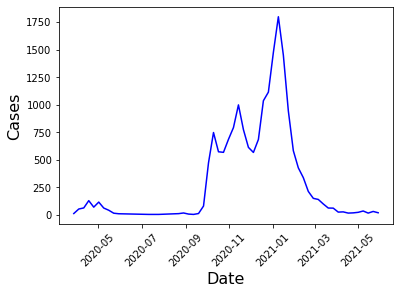

In [738]:
# shared axis
fig, ax = plt.subplots()
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(weekly_cases_devon['Date'], weekly_cases_devon['OriginalCases'], label="Shifted cases", color="blue")


## Correcting observations 
2 issues with recorded positive case data:
1.	There is a lag between the time of a positive test result and the time of infection
2.	Tests do not pick up all positive cases

Can correct this by:
1.	Shifting positive test results back in time (based on data on lag between infection and positive result)
2.	Using a multiplier on the number of positive cases (based on data on the proportion of positive case results being picked up by tests)


### Whole of Devon combined
#### Correcting for testing lag time
Evidence indicates that COVID-19 has a 5-6 day incubation   
Meaning symptoms will start 5-6 days after infection  
To convert positive case result data into infection data need to  
move positive test results back in time by 5-6 days  

In [721]:
# keep only up to May 2021
weekly_cases_devon_shifted = weekly_cases_devon.copy()

def shift_cases(df, n_days):
    # Shift back the date of the week by 6 days
    df['Date'] =  df['Date'] -  timedelta(days=n_days)
    # rename column
    df = df.rename(columns={df.columns[1]: 'ShiftedCases'})
    return df

# shift cases
weekly_cases_devon_shifted = shift_cases(weekly_cases_devon_shifted, 6)
# weekly_cases_devon_shifted

#### Plot the number of cases over time for original case data and time shifted case data

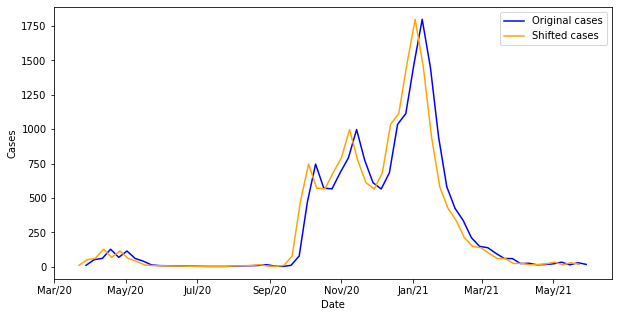

In [722]:
# Define formatting for dates
myFmt = mdates.DateFormatter('%b/%y')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.xaxis.set_major_formatter(myFmt)
# Plot observations
ax.plot(weekly_cases_devon['Date'], weekly_cases_devon['OriginalCases'], label="Original cases", color="blue")
ax.plot(weekly_cases_devon_shifted['Date'], weekly_cases_devon_shifted['ShiftedCases'], label="Shifted cases", color="orange")
# Plot result from manually calibrated model
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
# plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()

### Correcting for lack of testing: Apply multipliers
Tests do not pick up all positive cases. Therefore data on positive test results will not be a good representation of the number of actual cases in the population. An improved estimate of the number of infections in the population can be acquired through applying a multiplier to the positive cases data. Multipliers are applied to the data here based upon outputs of research by Phipps et al (2020), who applied a backcasting approach to estimate the true distribution of Covid in the population, and derived multipliers through comparison of this to the positive case data.

**NB: I just took multipliers from graph roughly, need exact figures**

Phipps, S.J., Grafton, R.Q. and Kompas, T., 2020. Robust estimates of the true (population) infection rate for COVID-19: a backcasting approach. Royal Society open science, 7(11), p.200909.

In [723]:
# Define multipliers (roughly taken from paper)
multipliers_dict = {'Mar2020':(100/3), 'Apr2020':(100/4),'May2020': (100/5), 'Jun2020':(100/6), 'Jul2020':(100/7), 
                    'Aug2020':(100/8),'Sep2020':(100/9),'Oct2020':(100/9),
                    'Nov2020':(100/9),'Dec2020':(100/9),'Jan2021':(100/9),'Feb2021':(100/9),
                    'Mar2021':(100/9), 'Apr2021':(100/9),'May2021':(100/9)}

# Loop through rows in cases datafrrame and check the month and year and then apply the correct multiplier
# Save the results into a list
def apply_multipliers(df):
    df_shifted_mxpld = df.copy()
    cases_col_name = list(df_shifted_mxpld.columns)
    infections= []
    for row in df_shifted_mxpld.itertuples():
        month = row.Date.strftime("%b")
        year = row.Date.strftime("%Y")
        multiplier = multipliers_dict[month+year]
        infections.append(row[2] * multiplier)

    # Add column to dataframe using the list
    df_shifted_mxpld['ShiftedInfections'] = infections
    return df_shifted_mxpld

weekly_cases_devon_shifted_mxpld = apply_multipliers(weekly_cases_devon_shifted)
weekly_cases_devon_mxpld = apply_multipliers(weekly_cases_devon)

#### Plotting
The number of cases over time for original case data, time shifted case data and time shifted infections (cases * multipliers) 

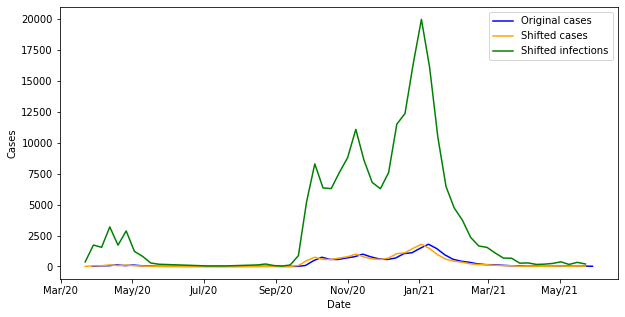

In [724]:
# Define formatting for dates
myFmt = mdates.DateFormatter('%b/%y')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.xaxis.set_major_formatter(myFmt)
# Plot observations
ax.plot(weekly_cases_devon['Date'], weekly_cases_devon['OriginalCases'], label="Original cases", color="blue")
ax.plot(weekly_cases_devon_shifted['Date'], weekly_cases_devon_shifted['ShiftedCases'], label="Shifted cases", color="orange")
ax.plot(weekly_cases_devon_shifted_mxpld['Date'], weekly_cases_devon_shifted_mxpld['ShiftedInfections'], label="Shifted infections", color="green")

# Plot result from manually calibrated model
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
# plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()


### Smoothing data
There is considerable noise (/outliers) in the recorded case data. To remove this, and to make patterns in the data more clear, the data can be smoothed using an algorithm.   

In this case, smoothing is achieved using a cubic smoothing spline. A cubic spline is a piecewise cubic function that interpolates a set of data points and guarantees smoothness at the data points. https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation

The smoothing parameter can be set manually and should be between 0 and 1. When 0, the smoothing spline is a least-squares straight line fit to the data, and when 1 it is the natural cubic spline interpolant (?). For 0 < p < 1, sp is a smoothing spline that is a trade-off between the two extremes: smoother than the interpolant s1 and closer to the data than the straight line s0.

https://towardsdatascience.com/numerical-interpolation-natural-cubic-spline-52c1157b98ac

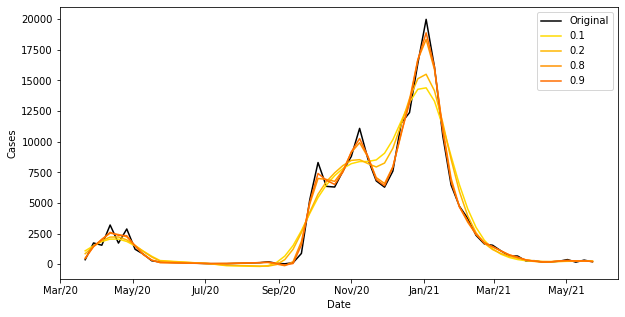

In [737]:
# Uses csaps package https://pypi.org/project/csaps/0.5.0/  

# Define function for smoothing
def smooth_with_cubic_splines(df, smooth_factor):
    df = df.copy()
    case_data = df['ShiftedInfections'].values
    case_data_locations = np.array(list(range(0, len(case_data))))
    xi = np.linspace(case_data_locations[0], case_data_locations[-1], len(case_data))
    df['SmoothedShiftedInfections'] = csaps(case_data_locations, case_data, xi, smooth=smooth_factor)
    return df

# Test different smoothness values
evenly_spaced_interval = np.linspace(0, 1, 8)
colors = [cm.autumn_r(x) for x in evenly_spaced_interval]
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.xaxis.set_major_formatter(myFmt)
ax.plot(weekly_cases_devon_shifted_mxpld['Date'], weekly_cases_devon_shifted_mxpld['ShiftedInfections'], label="Original", color="black")
for color_i, smooth_factor in zip([1,2,3,4,5], [0.1,0.2,0.8, 0.9]):
    weekly_cases_devon_shifted_mxpld_smoothed = smooth_with_cubic_splines(weekly_cases_devon_shifted_mxpld,smooth_factor )
    color = colors[color_i]
    # Plot observations
    ax.plot(weekly_cases_devon_shifted_mxpld_smoothed['Date'], weekly_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'], label=smooth_factor, color = color)
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()


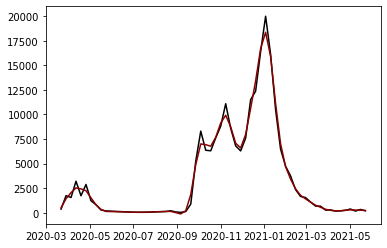

In [754]:
# Decide on smoothness factor,
# Add new column to dataframe, with smoothed version of shiftted infections data
smooth_factor =0.8
weekly_cases_devon_shifted_mxpld_smoothed =smooth_with_cubic_splines(weekly_cases_devon_shifted_mxpld.copy(), smooth_factor)
weekly_cases_devon_shifted_mxpld_smoothed.head()
plt.plot(weekly_cases_devon_shifted_mxpld['Date'], weekly_cases_devon_shifted_mxpld['ShiftedInfections'], label="Original", color="black")
plt.plot(weekly_cases_devon_shifted_mxpld_smoothed['Date'], weekly_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'], label="Original", color="darkred")

#### Save the corrected daily case data to file

In [450]:
# Save to file
# weekly_cases_devon_shifted_mxpld_smoothed.to_csv("weekly_cases_devon_corrected.csv", index = False)

#### Plotting

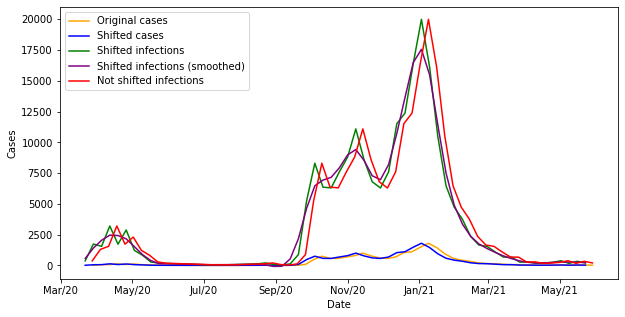

In [700]:
#Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.xaxis.set_major_formatter(myFmt)
# Plot observations
ax.plot(weekly_cases_devon['Date'], weekly_cases_devon['OriginalCases'], label="Original cases", color="orange")
ax.plot(weekly_cases_devon_shifted['Date'], weekly_cases_devon_shifted['ShiftedCases'], label="Shifted cases", color="blue")
ax.plot(weekly_cases_devon_shifted_mxpld['Date'], weekly_cases_devon_shifted_mxpld['ShiftedInfections'], label="Shifted infections", color="green")
ax.plot(weekly_cases_devon_shifted_mxpld_smoothed['Date'], weekly_cases_devon_shifted_mxpld_smoothed['SmoothedShiftedInfections'], label="Shifted infections (smoothed)", color="purple")
ax.plot(weekly_cases_devon_mxpld['Date'], weekly_cases_devon_mxpld['ShiftedInfections'], label="Not shifted infections", color="red")

# Plot result from manually calibrated model
#ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
# plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.show()

### Individual MSOAs

#### Shifting and multiplying case data

In [753]:
# Specify smooth_factor
smooth_factor = 0.8

# Create lists to store each MSOA dataframe from loop
shifted_dfs = []
shifted_multiplied_dfs = []
shifted_mxpld_smoothed_dfs = []

# Loop through each MSOA, extract data for just that MSOA
# shift cases, multiply cases and save to lists (to convert 
# later back into one dataframe with just shfited data and 
# one with just multiplied data - one column per MSOA)
for msoa_code in msoa_codes:
    # Take just one msoa's data, and format
    one_msoa = weekly_cases_msoas[['Date', msoa_code]]
    one_msoa = one_msoa.rename(columns={msoa_code:'Cases'})
    one_msoa.reset_index(drop = True, inplace = True)
    # # Shift cases
    one_msoa_shifted = shift_cases(one_msoa, 6)
    # Multiply cases
    one_msoa_shifted_multiplied = apply_multipliers(one_msoa_shifted)
    # Smooth cases
    one_msoa_shifted_mxplied_smoothed = smooth_with_cubic_splines(one_msoa_shifted_multiplied, smooth_factor)

    # rename column for shifted cases
    one_msoa_shifted = one_msoa_shifted.rename(columns={"ShiftedCases":msoa_code})
    # rename column for shifted, multiplied cases
    one_msoa_shifted_multiplied = one_msoa_shifted_multiplied.rename(columns={"ShiftedInfections":msoa_code})
    one_msoa_shifted_multiplied = one_msoa_shifted_multiplied.drop(['ShiftedCases'], axis=1)
    # rename column for shifted, multiplied, smoothed cases
    one_msoa_shifted_mxplied_smoothed = one_msoa_shifted_mxplied_smoothed.rename(columns={"SmoothedShiftedInfections":msoa_code})
    one_msoa_shifted_mxplied_smoothed = one_msoa_shifted_mxplied_smoothed.drop(['ShiftedCases', 'ShiftedInfections'], axis=1)

    # Add to shifted dataframe list
    if not shifted_dfs:
        shifted_dfs.append(one_msoa_shifted[['Date',msoa_code]])
    else:
        shifted_dfs.append(one_msoa_shifted[[msoa_code]])

    # Add to multiplied dataframe list
    if not shifted_multiplied_dfs:
        shifted_multiplied_dfs.append(one_msoa_shifted_multiplied[['Date',msoa_code]])
    else:
        shifted_multiplied_dfs.append(one_msoa_shifted_multiplied[[msoa_code]])   

    # Add to smoothed dataframe list
    if not shifted_mxpld_smoothed_dfs:
        shifted_mxpld_smoothed_dfs.append(one_msoa_shifted_mxplied_smoothed[['Date',msoa_code]])
    else:
        shifted_mxpld_smoothed_dfs.append(one_msoa_shifted_mxplied_smoothed[[msoa_code]])   
        
# Join list of dataframes into one - shifted       
weekly_cases_msoas_shifted = pd.concat(shifted_dfs, axis=1)
# Join list of dataframes into one - multiplied        
weekly_cases_msoas_shifted_mltpld = pd.concat(shifted_multiplied_dfs, axis=1)
# Join list of dataframes into one - smoothed        
weekly_cases_msoas_shifted_mltpld_smoothed = pd.concat(shifted_mxpld_smoothed_dfs, axis=1)

#### Plot for some msoas to test

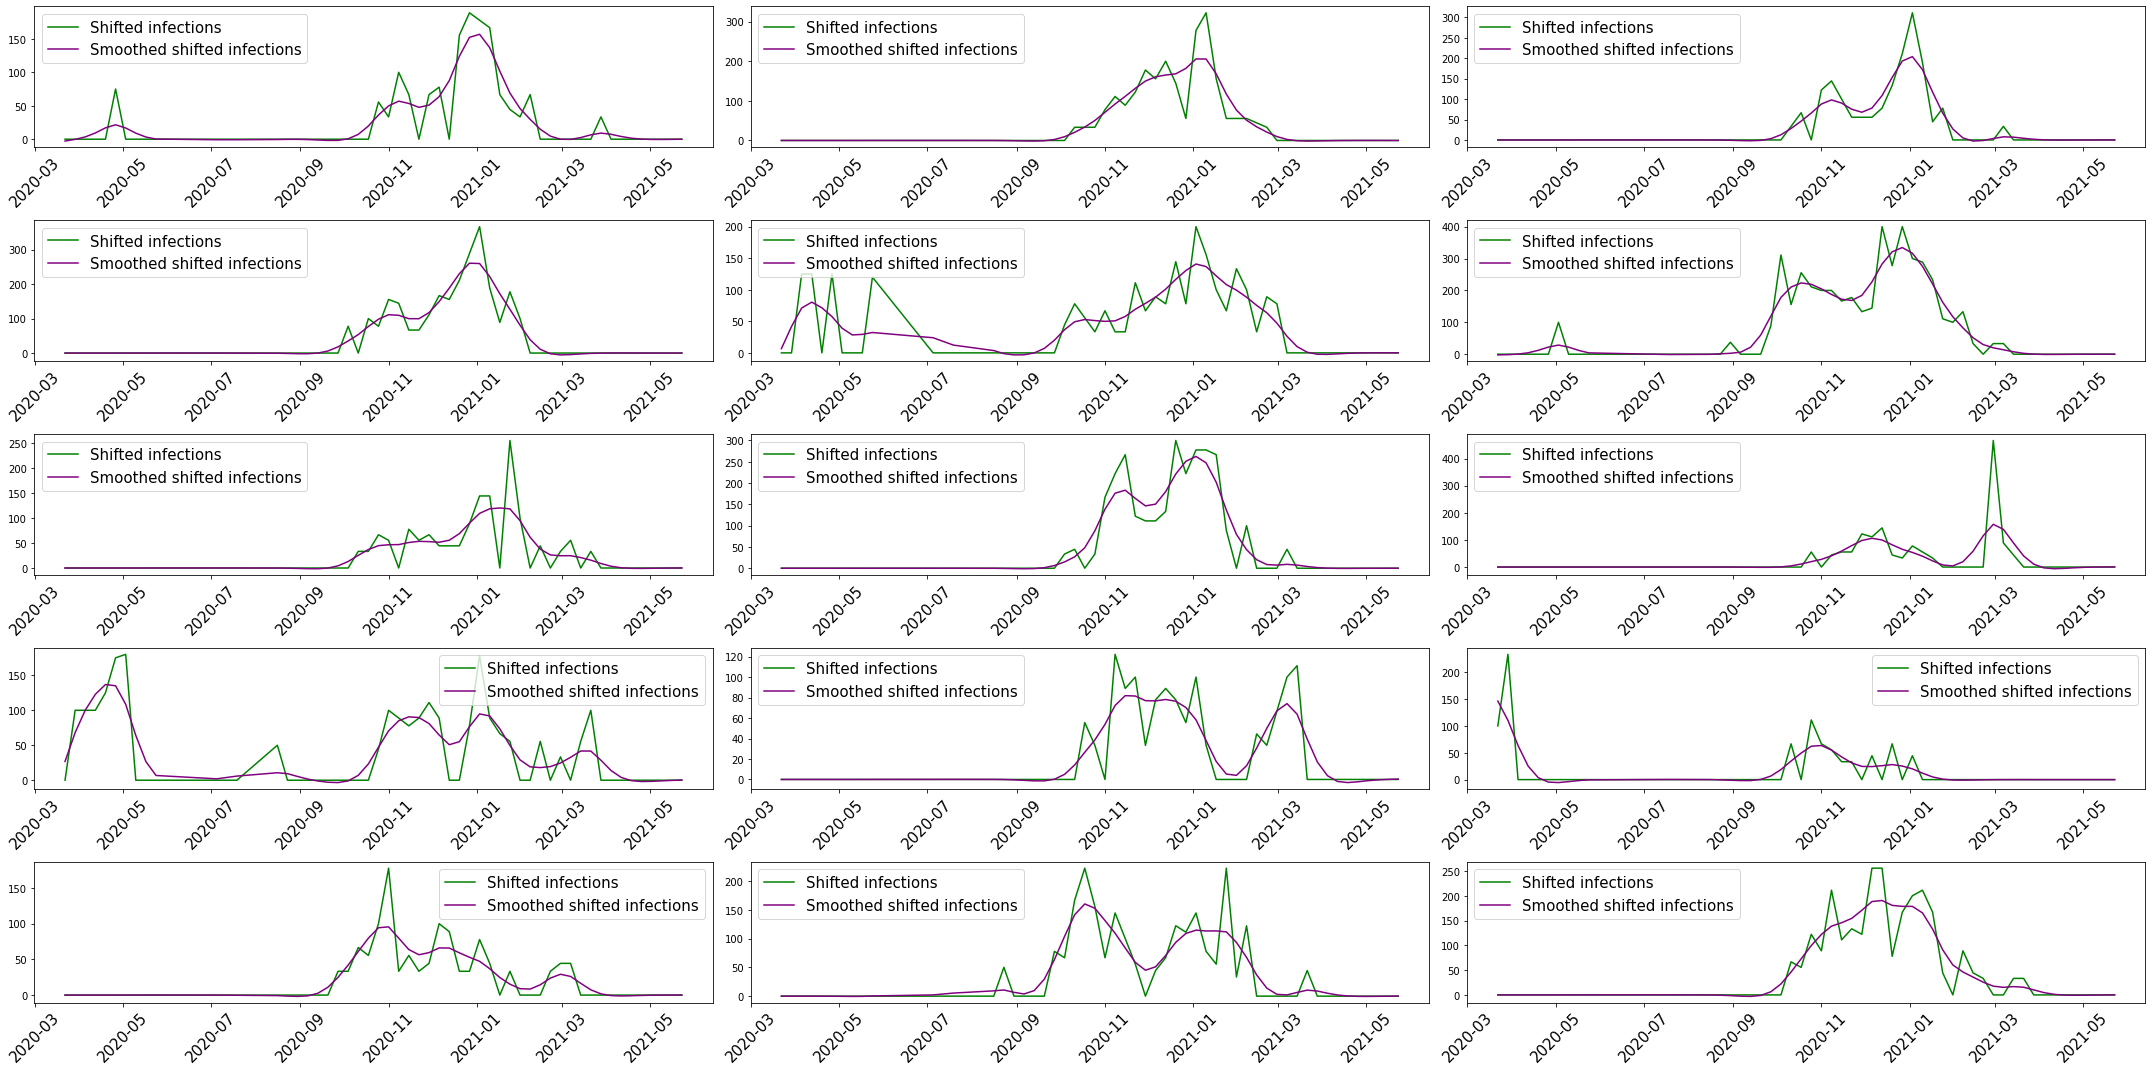

In [751]:
msoa_codes = weekly_cases_msoas.columns[1:]
fig, axs = plt.subplots(figsize =(30,15), nrows=5, ncols=3, sharey=False)
for i, ax in enumerate(fig.axes):
    msoa_code = msoa_codes[i]
    # Plot observations
#     ax.plot(weekly_cases_msoas['Date'], weekly_cases_msoas[msoa_code], label="Original cases", color="orange")
#     ax.plot(weekly_cases_msoas_shifted['Date'], weekly_cases_msoas_shifted[msoa_code], label="Shifted cases", color="blue")
    ax.plot(weekly_cases_msoas_shifted_mltpld['Date'], weekly_cases_msoas_shifted_mltpld[msoa_code], label="Shifted infections", color="green")
    ax.plot(weekly_cases_msoas_shifted_mltpld_smoothed['Date'], weekly_cases_msoas_shifted_mltpld_smoothed[msoa_code], label="Smoothed shifted infections", color="purple")
    ax.tick_params(axis='x', labelrotation=45, labelsize = 15 )
    ax.legend(fontsize =15)
# plt.suptitle("Comparing weekly data with weekly sums from daily data")
fig.tight_layout()
plt.show()

#### Try combining data for Devon after smoothing
Ends up being the same as combining it beforehand

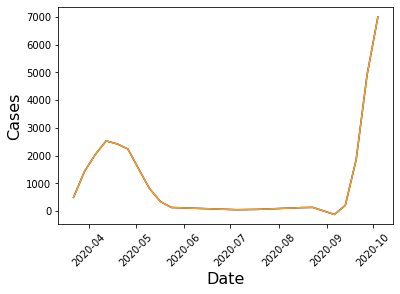

In [757]:
def find_devon_totals(df):
    totals_df = df.copy()
    # Add a row with the total number of cases across all MSOAs in each day
    totals_df['SmoothedShiftedInfections']= totals_df.iloc[:, 1:].sum(axis=1)
    # Remove columns with individual values for each MSOA
    totals_df = totals_df.drop(totals_df.iloc[:, 1:-1].columns, axis=1)
    totals_df.reset_index(inplace = True, drop = True)
    # Sort by date
    totals_df.sort_values(by='Date', inplace =True)
    return totals_df
    
weekly_cases_msoas_shifted_mltpld_smoothed_devon = find_devon_totals(weekly_cases_msoas_shifted_mltpld_smoothed) 
# shared axis
fig, ax = plt.subplots()
plt.xlabel("Date", fontsize= 16)
plt.ylabel("Cases", fontsize= 16)
# plt.title("n")
plt.xticks(rotation=45)
plt.plot(weekly_cases_msoas_shifted_mltpld_smoothed_devon[0:20]['Date'], weekly_cases_msoas_shifted_mltpld_smoothed_devon[0:20]['SmoothedShiftedInfections'], label="Shifted cases", color="blue")
plt.plot(weekly_cases_devon_shifted_mxpld_smoothed[0:20]['Date'], weekly_cases_devon_shifted_mxpld_smoothed[0:20]['SmoothedShiftedInfections'], label="Shifted cases", color="orange")


#### Save the corrected daily case data to file

In [ ]:
# save shifted, multiplied data
# daily_cases_msoas_shifted_mltpld_cases.to_csv("daily_cases_devon_msoas_corrected.csv", index= False)